# DTEK0042 Exercise 4

*** Note for Google Colab Users ***
     Because Google Colab doesn't have a button to convert your notebook to .html format here is a quick work around:
   1. open a new google colab notebook
   2. in the files section in google colab, upload the .ipynb file you want to be converted to .html
   3. in your new open notebook run this command in an empty cell: !jupyter nbconvert --to html YourFileName.ipynb
   4. after the command is finished running refresh the page
   5. In your files section you should see your original .ipynb file that you uploaded and then a .html file of that same notebook.
   6. download the .html file and you're good to go!

In this exercise, you are required to analyze a SCG signal step-by-step as outlined below.  The deliverables for this exercise are a jupyter notebook and a .html file exported form the notebook. The notebook should includes your code, observations, graphs, and conclusions made upon analyzing the given SCG signals. Please provide caption and description for every figure. 

## 1- library Imports

In [7]:
#scipy imports
#import scipy 
from scipy import signal,stats
from scipy.stats import skew, kurtosis 
#from scipy.signal import butter, filtfilt, freqz

#numpy imports
import numpy as np

#pandas import
import pandas as pd

#matplotlib imports
import matplotlib.pyplot as plt

#sklean imports
from sklearn.decomposition import PCA
from sklearn import preprocessing as prep
#other imports
import glob

# Data Import 
* Load the .txt files of SCG data that are stored in the folder named “dataset” into your python environment.  
* For each .txt data file, select the 3rd column which contains the Z-axis of the SCG signals. 
* Note: the sampling frequency of this signal is 200 Hz. 

        Hint:  
        * to automate the loading process you can get a list of all data file paths using glob package and subsequently load the files in a for loop. 
        
        * dataFiles = glob.glob(path_to_dataset) to get a list of file paths of "dataset\xxdata.txt"
        
         then load the paths one by one in a loop

In [9]:
path_to_dataset = "dataset/dataset/*.txt"  

data_files = glob.glob(path_to_dataset)

print(data_files)

z_axis_data = []

for file in data_files:
    data = np.loadtxt(file)

    z_axis = data[:, 2]
    z_axis_data.append(z_axis)

['dataset/dataset\\Noisy_data_1.txt', 'dataset/dataset\\Noisy_data_2.txt', 'dataset/dataset\\Noisy_data_3.txt', 'dataset/dataset\\Noisy_data_4.txt', 'dataset/dataset\\Normal_data_1.txt', 'dataset/dataset\\Normal_data_2.txt', 'dataset/dataset\\Normal_data_3.txt', 'dataset/dataset\\Normal_data_4.txt']


# Noisy Vs Normal Plotting

* Plot the z-axis SCG signal from the file "Noisy_data_1.txt" and plot the z-axis SCG signal from the file "Normal_data_1.txt" 
* Describe your observations and how the plots differ from one another.


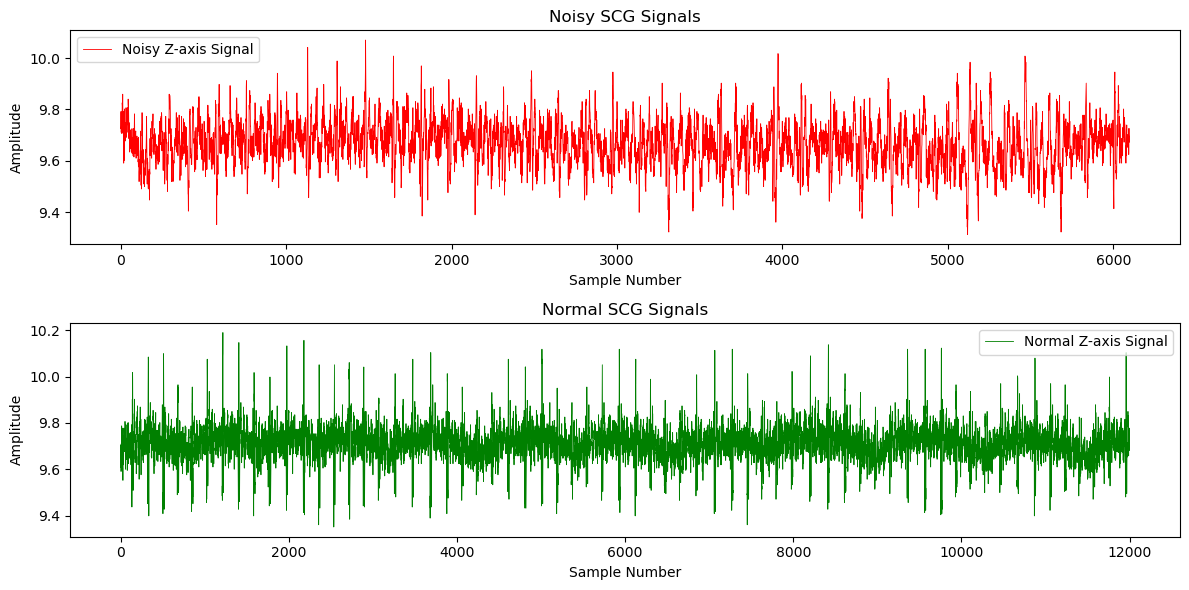

In [11]:
noisy_data = np.loadtxt("dataset/dataset\\Noisy_data_1.txt")[:, 2]  
normal_data = np.loadtxt("dataset/dataset\\Normal_data_1.txt")[:, 2]

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(noisy_data, color='red', linewidth=0.6, label='Noisy Z-axis Signal')
plt.title("Noisy SCG Signals")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(normal_data, color='green', linewidth=0.6, label='Normal Z-axis Signal')
plt.title("Normal SCG Signals")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

# Data Segmentation 
* Here is a simple function to use for data segmentation
* Segment the Z-axis signals into 5-second segments
* The sampling frequency used to record these signals is 200 Hz.
* Store the segments and the accompanying labels

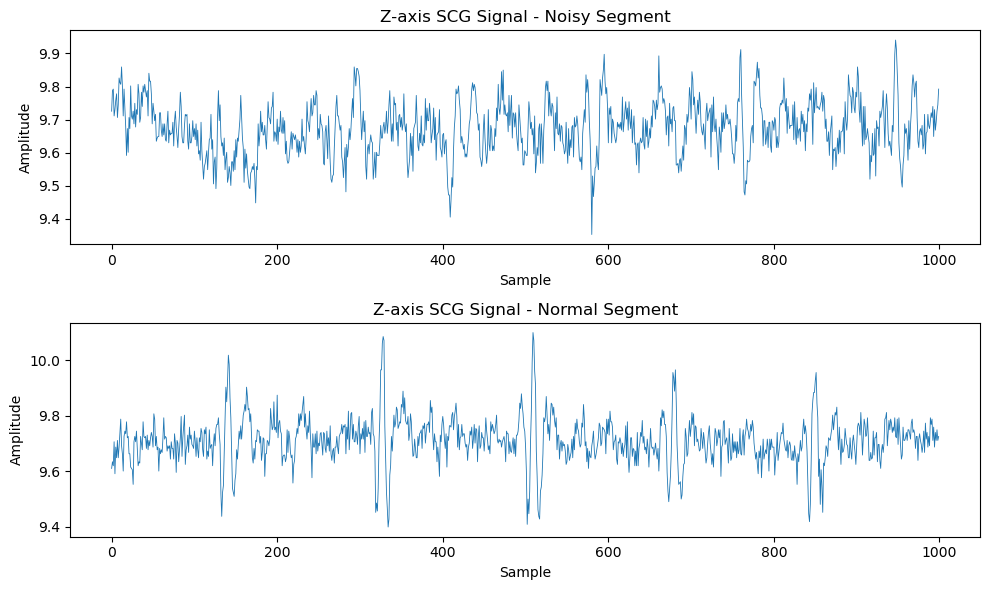

Total number of segments: 18
First noisy segment length: 1000 samples
First normal segment length: 1000 samples


In [14]:
#code (provided)

sampling_frequency = 200 
segment_duration = 5 
segment_length = sampling_frequency * segment_duration 

def _slicing(sig, file_label, sampling_frequency=200, segment_duration=5):
    """
    Inputs:
    sig : input array to be segmented
    file_label : label to be applied to segmented signal
    sampling_frequency : Sampling frequency of the signal in Hz
    segment_duration : Duration in seconds of each segment
    
    Outputs:
    sig_sliced : a list of segments
    label : a list of corresponding labels for the segmented signal 
    """
    
    segment_length = sampling_frequency * segment_duration 
    sig_sliced = []
    label = []
    
    for i in range(0, len(sig) // segment_length):
        start = i * segment_length
        end = start + segment_length
        sig_sliced.append(sig[start:end])
        label.append(file_label)
    
    return sig_sliced, label

noisy_data = np.loadtxt("dataset/dataset\\Noisy_data_1.txt")[:, 2] 
normal_data = np.loadtxt("dataset/dataset\\Normal_data_1.txt")[:, 2] 

noisy_segments, noisy_labels = _slicing(noisy_data, "noisy", sampling_frequency, segment_duration)
normal_segments, normal_labels = _slicing(normal_data, "normal", sampling_frequency, segment_duration)

all_segments = noisy_segments + normal_segments
all_labels = noisy_labels + normal_labels

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(noisy_segments[0], linewidth=.6)
plt.title("Z-axis SCG Signal - Noisy Segment")
plt.xlabel("Sample")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(normal_segments[0], linewidth=.6)
plt.title("Z-axis SCG Signal - Normal Segment")
plt.xlabel("Sample")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

print(f"Total number of segments: {len(all_segments)}")
print(f"First noisy segment length: {len(noisy_segments[0])} samples")
print(f"First normal segment length: {len(normal_segments[0])} samples")

# Feature Extraction Function Creation
*  Define a function and name it “feature_extraction” in which you compute and return the features listed below
    * *Time Domain Features*:  mean, standard deviation, interquartile-range, median, peak-to-peak range, skewness, kurtosis, and root mean square. 
    * *Frequency Domain Features*: power spectral density (using welch function of scipy)
    
        * For power spectral density, Calculate the total power spectral density within frequency bins of 4 Hz steps. Discard the frequencies above 40 Hz. Get the power within each bin.
    
        Hint:
        
        Reference: https://docs.scipy.org/doc/scipy/reference/stats.html for skewness, kurtosis, interquartile-range(iqr)
        
        Reference: https://numpy.org/doc/stable/reference/routines.statistics.html for other time domain features
        
        Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html for transforming to zero mean and unit variance



In [120]:
#code
def feature_extraction(sig, fs=200):
    """
    Extracts time domain and frequency domain features from a signal segment.
    
    Parameters:
    sig (array-like): Input signal array to extract features from.
    fs (int): Sampling frequency of input signal (default is 200 Hz).
    
    Returns:
    feature_array: A list containing all the features extracted from the signal.
    """
    
    feature_array = []
    
    ########################################## Statistical Features - Time Domain
    feature_array.append(np.mean(sig))               
    feature_array.append(np.std(sig))                 
    feature_array.append(stats.iqr(sig))            
    feature_array.append(np.median(sig))             
    feature_array.append(np.ptp(sig))               
    feature_array.append(stats.skew(sig))            
    feature_array.append(stats.kurtosis(sig))        
    feature_array.append(np.sqrt(np.mean(sig**2)))  
    ########################################## PSD - Frequency Domain
    transformed_sig = scale(sig)
    
    frequencies, PSD = signal.welch(transformed_sig, fs=fs, nperseg=256)
    
    freqs_arr = np.arange(0, 41, 4)
    PSD_binned_sum = []
    
    for i in range(len(freqs_arr) - 1):
        fmin, fmax = freqs_arr[i], freqs_arr[i + 1]
        bin_power = np.sum(PSD[(frequencies >= fmin) & (frequencies < fmax)])
        PSD_binned_sum.append(bin_power)
    
    feature_array.extend(PSD_binned_sum)
    
    return feature_array

# Feature Extraction Application

* You must first segment your signals and then extract features from each segment. You could do it in the following way:



* Call the _slicing function to section all the z-axis data into 5-second segments
        Hint: Load each file in "dataFiles" with for-loop
* Use the feature extraction function you created and extract features from every segment that you have obtained.
* Store the labels and the features you extracted from each segment to numpy arrays. 
        Hint: Think of an easy way to extract the label "noisy" or "normal" from each file name
        str.split() could be used somehow in this case

In [16]:
#code
def _slicing(sig, file_label, segment_length=1000):
    """
    Segment the signal into segments of length `segment_length`.
    """
    sig_sliced = []
    label = []

    for i in np.arange(int(len(sig) / segment_length)):
        sig_sliced.append(sig[i * segment_length:(i + 1) * segment_length])
        label.append(file_label)
        
    return sig_sliced, label

def feature_extraction(sig, fs=200):
    """
    Extract time-domain and frequency-domain features from the signal.
    """
    mean = np.mean(sig)
    std_dev = np.std(sig)
    iqr = np.percentile(sig, 75) - np.percentile(sig, 25)
    median = np.median(sig)
    peak_to_peak = np.ptp(sig)
    skewness = skew(sig)
    kurtosis_value = kurtosis(sig)
    rms = np.sqrt(np.mean(np.square(sig)))
    
    freqs, PSD = signal.welch(sig, fs, nperseg=len(sig))
    
    freqs_bins = np.arange(0, 41, 4)
    PSD_binned_sum = []

    for i in range(len(freqs_bins) - 1):
        bin_sum = np.sum(PSD[(freqs >= freqs_bins[i]) & (freqs < freqs_bins[i + 1])])
        PSD_binned_sum.append(bin_sum)

    features = np.array([
        mean, std_dev, iqr, median, peak_to_peak, skewness, kurtosis_value, rms,
        *PSD_binned_sum
    ])
    
    return features

data_path = "dataset/dataset/*.txt"
data_files = glob.glob(data_path) 

all_features = []
all_labels = []


for file in data_files:
    
    label = "noisy" if "Noisy" in file else "normal"
    
    try:
        data = np.loadtxt(file)[:, 2]  
        print(f"Data from {file}: {data[:10]}")  # Preview first 10 data points
    except Exception as e:
        print(f"Error loading file {file}: {e}")
        continue
    
    segments, labels = _slicing(data, label, segment_length=1000)
    
    print(f"Number of segments for {file}: {len(segments)}")
    
    for segment in segments:
        features = feature_extraction(segment)
        print(f"Extracted features: {features}")
        all_features.append(features)
        all_labels.append(label)

features_array = np.array(all_features)
labels_array = np.array(all_labels)

print("Features array shape:", features_array.shape)
print("Labels array shape:", labels_array.shape)

Data from dataset/dataset\Noisy_data_1.txt: [9.725235 9.787491 9.792267 9.710876 9.730026 9.758759 9.777908 9.706085
 9.744385 9.82579 ]
Number of segments for dataset/dataset\Noisy_data_1.txt: 6
Extracted features: [ 9.67437221e+00  8.04520806e-02  1.05347000e-01  9.67256200e+00
  5.88974000e-01 -1.85988981e-02  2.32403423e-01  9.67470673e+00
  3.84956355e-03  9.08140054e-03  8.78336920e-03  1.70660266e-03
  1.35273063e-03  5.40711563e-04  6.08603315e-04  6.06358002e-04
  4.65010001e-04  4.32470734e-04]
Extracted features: [9.69999006e+00 8.55342527e-02 1.00555000e-01 9.69889850e+00
 6.84738000e-01 1.82033190e-01 1.12110200e+00 9.70036717e+00
 4.49509346e-03 7.50048207e-03 7.17797617e-03 4.58111017e-03
 3.62258057e-03 7.76273340e-04 3.66451594e-04 4.66466763e-04
 3.24122775e-04 3.42151024e-04]
Extracted features: [9.67504716e+00 8.26067914e-02 1.05347000e-01 9.67735300e+00
 5.60242000e-01 8.06223542e-02 2.28225469e-01 9.67539981e+00
 2.41219420e-03 1.03677224e-02 7.63658509e-03 3.6049

# Standardize Features
Hint:

    Use sklearn.preprocessing.scale() to standardize the features
    Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html

In [18]:
#code
from sklearn.preprocessing import scale 

features_array = np.array(all_features)

features_array_standardized = scale(features_array)

print("Features array shape after standardization:", features_array_standardized.shape)
print("Labels array shape:", labels_array.shape)


Features array shape after standardization: (75, 18)
Labels array shape: (75,)


# Principal Component Analysis
* Principal Component Analysis (PCA) is used to reduce the dimensionality of a data set consisting of many variables correlated with each other. This can then be used to visualize the data in a more practical way. 
* Compute the first and 2nd principal components
* Plot the two components on a scatter plot with the coloring done by label
* Are these features useful to seperate the two types of signals (noisy vs normal)?
* Describe your observations.
    
        Hint:
        my_pca=PCA(n_components=2)
        pca_out = my_pca.fit_transform(input)

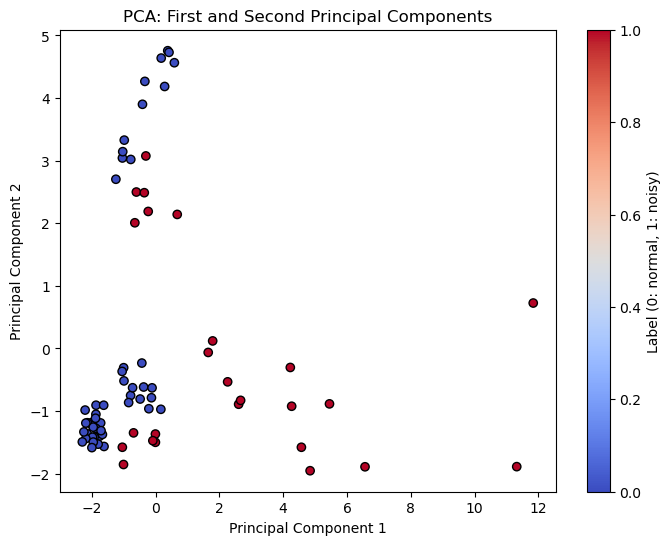

In [20]:
#code
my_pca = PCA(n_components=2)
pca_out = my_pca.fit_transform(features_array_standardized)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_out[:, 0], pca_out[:, 1], c=[1 if label == 'noisy' else 0 for label in labels_array], cmap='coolwarm', edgecolors='k')

plt.title("PCA: First and Second Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Label (0: normal, 1: noisy)")

plt.show()

# Observations 
    This visualization of the first and second principal components provides valuable insights into how well the features distinguish between `normal` and `noisy` signals. The scatter plot shows clear separation between the two groups, it indicates that the extracted features, such as time-domain and frequency-domain statistics, are effective at distinguishing the two signal types. The points form different clusters which suggests that PCA has successfully reduced the dimensionality while preserving the structure of the data. It indicates that the features are useful for signal classification.|